# Training with Data Augmentation and some improving

I introduced a preprocessing to change the background color during the training, batch size 16.

The accuracy on Codalab is near 56.5%, worse than the prevous one which was 63.3%

In [ ]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!unzip ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/no_tomato.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: no_tomato/train/Orange/05632.jpg  
  inflating: no_tomato/train/Blueberry/01844.jpg  
  inflating: no_tomato/train/Blueberry/02102.jpg  
  inflating: no_tomato/train/Blueberry/02139.jpg  
  inflating: no_tomato/train/Blueberry/01828.jpg  
  inflating: no_tomato/train/Blueberry/02064.jpg  
  inflating: no_tomato/train/Blueberry/02196.jpg  
  inflating: no_tomato/train/Blueberry/01871.jpg  
  inflating: no_tomato/train/Peach/31641.jpg  
  inflating: no_tomato/train/Peach/31590.jpg  
  inflating: no_tomato/train/Blueberry/02223.jpg  
  inflating: no_tomato/train/Peach/32207.jpg  
  inflating: no_tomato/train/Blueberry/02168.jpg  
  inflating: no_tomato/train/Blueberry/02052.jpg  
  inflating: no_tomato/train/Blueberry/02014.jpg  
  inflating: no_tomato/train/Grape/05319.jpg  
  inflating: no_tomato/train/Grape/05467.jpg  
  inflating: no_tomato/train/Blueberry/01697.jpg  
  inflating: no_tomato/train/Peach/31447.jpg  
  inflat

#Imports

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


#Loading data & folder Exploring

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
dataset_dir = 'no_tomato'

training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

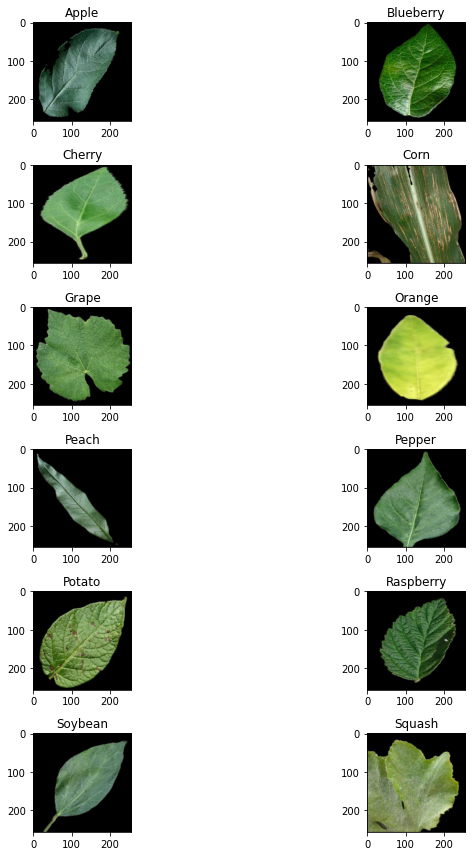

In [ ]:
# Plot example images from dataset
labels = labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,6*num_col))

for i in range(num_row*num_col):
  if i < 21:
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))
    class_imgs = class_imgs[2]
    
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

#Data Generator

Import:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import cv2
from random import randint
def myFunc(image):
    image = np.array(image)
    if random.random() > 0.5:
      image[image[:, :, 0] <= 10] = 1

    return image

# Create an instance of ImageDataGenerator with Data Augmentation
noaug_train_data_gen = ImageDataGenerator(rotation_range=180, height_shift_range=70, width_shift_range=120, zoom_range=0.6, horizontal_flip=True, vertical_flip=True, fill_mode='constant', cval=0, rescale=1/255., preprocessing_function=myFunc)
valid_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)


# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
noaug_train_gen = noaug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=16,
                                               shuffle=True,
                                               seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=16,
                                               shuffle=False,
                                               seed=seed)

test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=16,
                                               shuffle=False,
                                               seed=seed)


Found 9022 images belonging to 13 classes.
Found 1799 images belonging to 13 classes.
Found 1214 images belonging to 13 classes.


# Check example - Data Augmentation

In [ ]:
image = next(noaug_train_gen)[0]


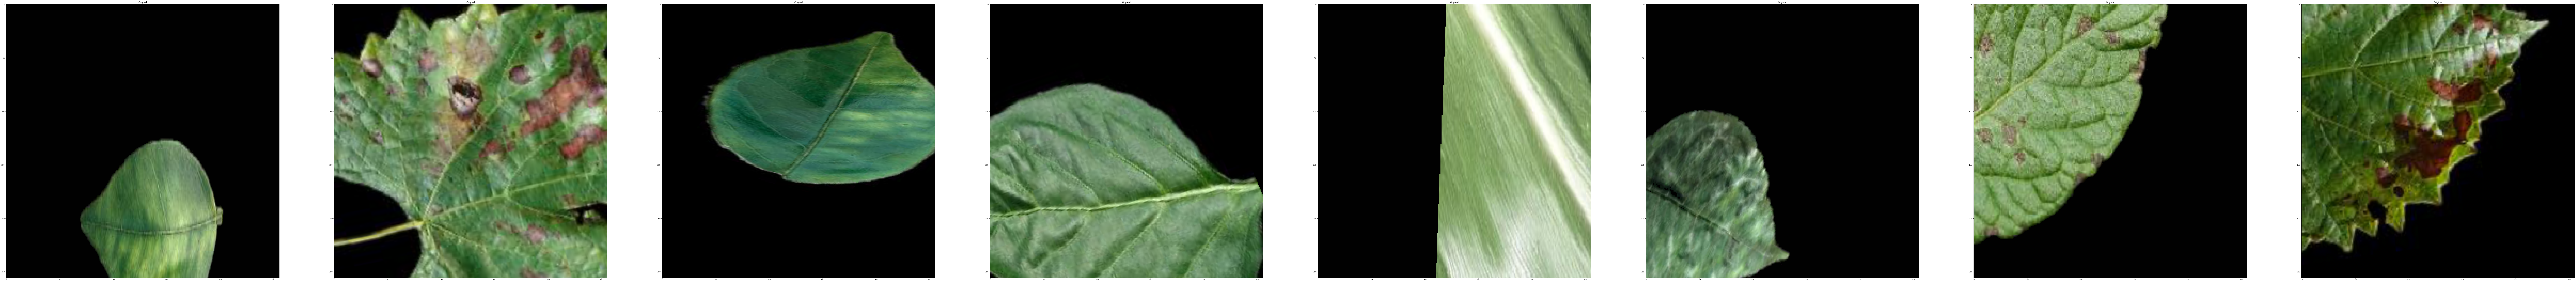

In [ ]:
fig, ax = plt.subplots(1, 8, figsize=(255, 255))
init = 0
for i in range(init, init+8):
  
  ax[i-init].imshow(np.array(image[i]))
  ax[i-init].set_title('Original')

#Characteristics

In [ ]:
input_shape = (256, 256, 3)
epochs = 200

#Declaring Network

In [ ]:
# Model used:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=13, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.CategoricalAccuracy(), 'accuracy'])

    # Return the model
    return model

#Building Model

In [ ]:
# Build model
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496 

# Save checkpoints

In [ ]:
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check') #this is the directory in which will be saved all checkpoints of LucaA of all experiments
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now)) #here will be saved the checkpoints of this single experiment
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = [] #declare a list of empty callbacks

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts') #In the directory of the experiment will be created the directory ckpts
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

#Training the model

In [ ]:
noaug_callbacks = create_folders_and_callbacks(model_name='v2_DA_no_tomatooo')

# Train the model
history = model.fit(
    x = noaug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = noaug_callbacks,
).history

Epoch 1/200
564/564 [==============================] - ETA: 0s - loss: 2.1973 - categorical_accuracy: 0.2588 - accuracy: 0.2588

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 131s 203ms/step - loss: 2.1973 - categorical_accuracy: 0.2588 - accuracy: 0.2588 - val_loss: 2.0541 - val_categorical_accuracy: 0.2991 - val_accuracy: 0.2991
Epoch 2/200
564/564 [==============================] - ETA: 0s - loss: 1.9306 - categorical_accuracy: 0.3404 - accuracy: 0.3404

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 113s 201ms/step - loss: 1.9306 - categorical_accuracy: 0.3404 - accuracy: 0.3404 - val_loss: 1.7859 - val_categorical_accuracy: 0.4041 - val_accuracy: 0.4041
Epoch 3/200
564/564 [==============================] - ETA: 0s - loss: 1.7608 - categorical_accuracy: 0.3973 - accuracy: 0.3973

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 114s 202ms/step - loss: 1.7608 - categorical_accuracy: 0.3973 - accuracy: 0.3973 - val_loss: 1.5572 - val_categorical_accuracy: 0.4391 - val_accuracy: 0.4391
Epoch 4/200
564/564 [==============================] - ETA: 0s - loss: 1.5739 - categorical_accuracy: 0.4655 - accuracy: 0.4655

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 114s 202ms/step - loss: 1.5739 - categorical_accuracy: 0.4655 - accuracy: 0.4655 - val_loss: 1.5450 - val_categorical_accuracy: 0.4875 - val_accuracy: 0.4875
Epoch 5/200
564/564 [==============================] - ETA: 0s - loss: 1.4387 - categorical_accuracy: 0.5151 - accuracy: 0.5151

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 113s 200ms/step - loss: 1.4387 - categorical_accuracy: 0.5151 - accuracy: 0.5151 - val_loss: 1.4980 - val_categorical_accuracy: 0.5019 - val_accuracy: 0.5019
Epoch 6/200
564/564 [==============================] - ETA: 0s - loss: 1.3031 - categorical_accuracy: 0.5612 - accuracy: 0.5612

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 113s 201ms/step - loss: 1.3031 - categorical_accuracy: 0.5612 - accuracy: 0.5612 - val_loss: 1.2552 - val_categorical_accuracy: 0.5703 - val_accuracy: 0.5703
Epoch 7/200
564/564 [==============================] - ETA: 0s - loss: 1.1541 - categorical_accuracy: 0.6160 - accuracy: 0.6160

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 116s 206ms/step - loss: 1.1541 - categorical_accuracy: 0.6160 - accuracy: 0.6160 - val_loss: 1.0516 - val_categorical_accuracy: 0.6448 - val_accuracy: 0.6448
Epoch 8/200
564/564 [==============================] - ETA: 0s - loss: 1.0669 - categorical_accuracy: 0.6455 - accuracy: 0.6455

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 113s 201ms/step - loss: 1.0669 - categorical_accuracy: 0.6455 - accuracy: 0.6455 - val_loss: 1.0785 - val_categorical_accuracy: 0.6509 - val_accuracy: 0.6509
Epoch 9/200
564/564 [==============================] - ETA: 0s - loss: 0.9923 - categorical_accuracy: 0.6650 - accuracy: 0.6650

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 114s 202ms/step - loss: 0.9923 - categorical_accuracy: 0.6650 - accuracy: 0.6650 - val_loss: 0.8023 - val_categorical_accuracy: 0.7226 - val_accuracy: 0.7226
Epoch 10/200
564/564 [==============================] - ETA: 0s - loss: 0.9212 - categorical_accuracy: 0.6934 - accuracy: 0.6934

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 117s 208ms/step - loss: 0.9212 - categorical_accuracy: 0.6934 - accuracy: 0.6934 - val_loss: 0.7618 - val_categorical_accuracy: 0.7437 - val_accuracy: 0.7437
Epoch 11/200
564/564 [==============================] - ETA: 0s - loss: 0.8555 - categorical_accuracy: 0.7137 - accuracy: 0.7137

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 113s 200ms/step - loss: 0.8555 - categorical_accuracy: 0.7137 - accuracy: 0.7137 - val_loss: 0.7864 - val_categorical_accuracy: 0.7443 - val_accuracy: 0.7443
Epoch 12/200
564/564 [==============================] - ETA: 0s - loss: 0.8123 - categorical_accuracy: 0.7247 - accuracy: 0.7247

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 114s 202ms/step - loss: 0.8123 - categorical_accuracy: 0.7247 - accuracy: 0.7247 - val_loss: 0.5159 - val_categorical_accuracy: 0.8243 - val_accuracy: 0.8243
Epoch 13/200
564/564 [==============================] - ETA: 0s - loss: 0.7522 - categorical_accuracy: 0.7471 - accuracy: 0.7471

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 117s 207ms/step - loss: 0.7522 - categorical_accuracy: 0.7471 - accuracy: 0.7471 - val_loss: 0.5191 - val_categorical_accuracy: 0.8232 - val_accuracy: 0.8232
Epoch 14/200
564/564 [==============================] - ETA: 0s - loss: 0.7150 - categorical_accuracy: 0.7638 - accuracy: 0.7638

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 118s 209ms/step - loss: 0.7150 - categorical_accuracy: 0.7638 - accuracy: 0.7638 - val_loss: 0.7196 - val_categorical_accuracy: 0.7743 - val_accuracy: 0.7743
Epoch 15/200
564/564 [==============================] - ETA: 0s - loss: 0.7233 - categorical_accuracy: 0.7670 - accuracy: 0.7670

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 117s 208ms/step - loss: 0.7233 - categorical_accuracy: 0.7670 - accuracy: 0.7670 - val_loss: 0.7217 - val_categorical_accuracy: 0.7660 - val_accuracy: 0.7660
Epoch 16/200
564/564 [==============================] - ETA: 0s - loss: 0.6531 - categorical_accuracy: 0.7791 - accuracy: 0.7791

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 119s 210ms/step - loss: 0.6531 - categorical_accuracy: 0.7791 - accuracy: 0.7791 - val_loss: 0.5914 - val_categorical_accuracy: 0.8088 - val_accuracy: 0.8088
Epoch 17/200
564/564 [==============================] - ETA: 0s - loss: 0.6499 - categorical_accuracy: 0.7855 - accuracy: 0.7855

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 117s 207ms/step - loss: 0.6499 - categorical_accuracy: 0.7855 - accuracy: 0.7855 - val_loss: 0.4617 - val_categorical_accuracy: 0.8460 - val_accuracy: 0.8460
Epoch 18/200
564/564 [==============================] - ETA: 0s - loss: 0.6258 - categorical_accuracy: 0.7955 - accuracy: 0.7955

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 112s 198ms/step - loss: 0.6258 - categorical_accuracy: 0.7955 - accuracy: 0.7955 - val_loss: 0.3791 - val_categorical_accuracy: 0.8783 - val_accuracy: 0.8783
Epoch 19/200
564/564 [==============================] - ETA: 0s - loss: 0.6174 - categorical_accuracy: 0.7989 - accuracy: 0.7989

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 111s 197ms/step - loss: 0.6174 - categorical_accuracy: 0.7989 - accuracy: 0.7989 - val_loss: 0.5378 - val_categorical_accuracy: 0.8155 - val_accuracy: 0.8155
Epoch 20/200
564/564 [==============================] - ETA: 0s - loss: 0.5898 - categorical_accuracy: 0.8031 - accuracy: 0.8031

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 111s 198ms/step - loss: 0.5898 - categorical_accuracy: 0.8031 - accuracy: 0.8031 - val_loss: 0.4917 - val_categorical_accuracy: 0.8321 - val_accuracy: 0.8321
Epoch 21/200
564/564 [==============================] - ETA: 0s - loss: 0.5899 - categorical_accuracy: 0.8123 - accuracy: 0.8123

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 112s 198ms/step - loss: 0.5899 - categorical_accuracy: 0.8123 - accuracy: 0.8123 - val_loss: 0.4689 - val_categorical_accuracy: 0.8410 - val_accuracy: 0.8410
Epoch 22/200
564/564 [==============================] - ETA: 0s - loss: 0.5492 - categorical_accuracy: 0.8170 - accuracy: 0.8170

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 112s 199ms/step - loss: 0.5492 - categorical_accuracy: 0.8170 - accuracy: 0.8170 - val_loss: 0.5081 - val_categorical_accuracy: 0.8355 - val_accuracy: 0.8355
Epoch 23/200
564/564 [==============================] - ETA: 0s - loss: 0.5504 - categorical_accuracy: 0.8234 - accuracy: 0.8234

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 112s 199ms/step - loss: 0.5504 - categorical_accuracy: 0.8234 - accuracy: 0.8234 - val_loss: 0.3898 - val_categorical_accuracy: 0.8677 - val_accuracy: 0.8677
Epoch 24/200
564/564 [==============================] - ETA: 0s - loss: 0.5576 - categorical_accuracy: 0.8217 - accuracy: 0.8217

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 113s 200ms/step - loss: 0.5576 - categorical_accuracy: 0.8217 - accuracy: 0.8217 - val_loss: 0.3604 - val_categorical_accuracy: 0.8772 - val_accuracy: 0.8772
Epoch 25/200
564/564 [==============================] - ETA: 0s - loss: 0.5313 - categorical_accuracy: 0.8247 - accuracy: 0.8247

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 112s 199ms/step - loss: 0.5313 - categorical_accuracy: 0.8247 - accuracy: 0.8247 - val_loss: 0.3406 - val_categorical_accuracy: 0.8827 - val_accuracy: 0.8827
Epoch 26/200
564/564 [==============================] - ETA: 0s - loss: 0.5362 - categorical_accuracy: 0.8269 - accuracy: 0.8269

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 116s 206ms/step - loss: 0.5362 - categorical_accuracy: 0.8269 - accuracy: 0.8269 - val_loss: 0.3584 - val_categorical_accuracy: 0.8827 - val_accuracy: 0.8827
Epoch 27/200
564/564 [==============================] - ETA: 0s - loss: 0.5054 - categorical_accuracy: 0.8374 - accuracy: 0.8374

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 116s 205ms/step - loss: 0.5054 - categorical_accuracy: 0.8374 - accuracy: 0.8374 - val_loss: 0.3323 - val_categorical_accuracy: 0.8933 - val_accuracy: 0.8933
Epoch 28/200
564/564 [==============================] - ETA: 0s - loss: 0.4946 - categorical_accuracy: 0.8405 - accuracy: 0.8405

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 112s 199ms/step - loss: 0.4946 - categorical_accuracy: 0.8405 - accuracy: 0.8405 - val_loss: 0.5800 - val_categorical_accuracy: 0.8310 - val_accuracy: 0.8310
Epoch 29/200
564/564 [==============================] - ETA: 0s - loss: 0.4924 - categorical_accuracy: 0.8409 - accuracy: 0.8409

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 112s 198ms/step - loss: 0.4924 - categorical_accuracy: 0.8409 - accuracy: 0.8409 - val_loss: 0.3697 - val_categorical_accuracy: 0.8849 - val_accuracy: 0.8849
Epoch 30/200
564/564 [==============================] - ETA: 0s - loss: 0.4982 - categorical_accuracy: 0.8434 - accuracy: 0.8434

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 112s 199ms/step - loss: 0.4982 - categorical_accuracy: 0.8434 - accuracy: 0.8434 - val_loss: 0.3192 - val_categorical_accuracy: 0.8922 - val_accuracy: 0.8922
Epoch 31/200
564/564 [==============================] - ETA: 0s - loss: 0.4580 - categorical_accuracy: 0.8513 - accuracy: 0.8513

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 112s 198ms/step - loss: 0.4580 - categorical_accuracy: 0.8513 - accuracy: 0.8513 - val_loss: 0.3587 - val_categorical_accuracy: 0.8766 - val_accuracy: 0.8766
Epoch 32/200
564/564 [==============================] - ETA: 0s - loss: 0.4863 - categorical_accuracy: 0.8493 - accuracy: 0.8493

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 112s 198ms/step - loss: 0.4863 - categorical_accuracy: 0.8493 - accuracy: 0.8493 - val_loss: 0.3610 - val_categorical_accuracy: 0.8827 - val_accuracy: 0.8827
Epoch 33/200
564/564 [==============================] - ETA: 0s - loss: 0.4602 - categorical_accuracy: 0.8508 - accuracy: 0.8508

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 116s 205ms/step - loss: 0.4602 - categorical_accuracy: 0.8508 - accuracy: 0.8508 - val_loss: 0.3134 - val_categorical_accuracy: 0.8994 - val_accuracy: 0.8994
Epoch 34/200
564/564 [==============================] - ETA: 0s - loss: 0.4586 - categorical_accuracy: 0.8538 - accuracy: 0.8538

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 117s 207ms/step - loss: 0.4586 - categorical_accuracy: 0.8538 - accuracy: 0.8538 - val_loss: 0.4696 - val_categorical_accuracy: 0.8527 - val_accuracy: 0.8527
Epoch 35/200
564/564 [==============================] - ETA: 0s - loss: 0.4464 - categorical_accuracy: 0.8607 - accuracy: 0.8607

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 116s 206ms/step - loss: 0.4464 - categorical_accuracy: 0.8607 - accuracy: 0.8607 - val_loss: 0.3891 - val_categorical_accuracy: 0.8844 - val_accuracy: 0.8844
Epoch 36/200
564/564 [==============================] - ETA: 0s - loss: 0.4590 - categorical_accuracy: 0.8542 - accuracy: 0.8542

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 117s 207ms/step - loss: 0.4590 - categorical_accuracy: 0.8542 - accuracy: 0.8542 - val_loss: 0.2930 - val_categorical_accuracy: 0.9077 - val_accuracy: 0.9077
Epoch 37/200
564/564 [==============================] - ETA: 0s - loss: 0.4275 - categorical_accuracy: 0.8629 - accuracy: 0.8629

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 114s 203ms/step - loss: 0.4275 - categorical_accuracy: 0.8629 - accuracy: 0.8629 - val_loss: 0.2317 - val_categorical_accuracy: 0.9277 - val_accuracy: 0.9277
Epoch 38/200
564/564 [==============================] - ETA: 0s - loss: 0.4381 - categorical_accuracy: 0.8601 - accuracy: 0.8601

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 117s 208ms/step - loss: 0.4381 - categorical_accuracy: 0.8601 - accuracy: 0.8601 - val_loss: 0.4009 - val_categorical_accuracy: 0.8699 - val_accuracy: 0.8699
Epoch 39/200
564/564 [==============================] - ETA: 0s - loss: 0.4339 - categorical_accuracy: 0.8612 - accuracy: 0.8612

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 118s 209ms/step - loss: 0.4339 - categorical_accuracy: 0.8612 - accuracy: 0.8612 - val_loss: 0.2531 - val_categorical_accuracy: 0.9138 - val_accuracy: 0.9138
Epoch 40/200
564/564 [==============================] - ETA: 0s - loss: 0.4149 - categorical_accuracy: 0.8688 - accuracy: 0.8688

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 117s 207ms/step - loss: 0.4149 - categorical_accuracy: 0.8688 - accuracy: 0.8688 - val_loss: 0.7587 - val_categorical_accuracy: 0.8071 - val_accuracy: 0.8071
Epoch 41/200
564/564 [==============================] - ETA: 0s - loss: 0.4232 - categorical_accuracy: 0.8628 - accuracy: 0.8628

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 117s 207ms/step - loss: 0.4232 - categorical_accuracy: 0.8628 - accuracy: 0.8628 - val_loss: 0.3308 - val_categorical_accuracy: 0.8961 - val_accuracy: 0.8961
Epoch 42/200
564/564 [==============================] - ETA: 0s - loss: 0.4211 - categorical_accuracy: 0.8671 - accuracy: 0.8671

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 116s 205ms/step - loss: 0.4211 - categorical_accuracy: 0.8671 - accuracy: 0.8671 - val_loss: 0.2448 - val_categorical_accuracy: 0.9227 - val_accuracy: 0.9227
Epoch 43/200
564/564 [==============================] - ETA: 0s - loss: 0.4014 - categorical_accuracy: 0.8721 - accuracy: 0.8721

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 116s 205ms/step - loss: 0.4014 - categorical_accuracy: 0.8721 - accuracy: 0.8721 - val_loss: 0.3810 - val_categorical_accuracy: 0.8799 - val_accuracy: 0.8799
Epoch 44/200
564/564 [==============================] - ETA: 0s - loss: 0.4199 - categorical_accuracy: 0.8646 - accuracy: 0.8646

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 115s 204ms/step - loss: 0.4199 - categorical_accuracy: 0.8646 - accuracy: 0.8646 - val_loss: 0.3269 - val_categorical_accuracy: 0.9044 - val_accuracy: 0.9044
Epoch 45/200
564/564 [==============================] - ETA: 0s - loss: 0.4101 - categorical_accuracy: 0.8685 - accuracy: 0.8685

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 115s 203ms/step - loss: 0.4101 - categorical_accuracy: 0.8685 - accuracy: 0.8685 - val_loss: 0.2886 - val_categorical_accuracy: 0.9105 - val_accuracy: 0.9105
Epoch 46/200
564/564 [==============================] - ETA: 0s - loss: 0.4160 - categorical_accuracy: 0.8688 - accuracy: 0.8688

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 115s 204ms/step - loss: 0.4160 - categorical_accuracy: 0.8688 - accuracy: 0.8688 - val_loss: 0.3134 - val_categorical_accuracy: 0.9027 - val_accuracy: 0.9027
Epoch 47/200
564/564 [==============================] - ETA: 0s - loss: 0.4120 - categorical_accuracy: 0.8721 - accuracy: 0.8721

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_10-21-39/ckpts/cp.ckpt/assets


564/564 [==============================] - 115s 204ms/step - loss: 0.4120 - categorical_accuracy: 0.8721 - accuracy: 0.8721 - val_loss: 0.2597 - val_categorical_accuracy: 0.9099 - val_accuracy: 0.9099


#Saving the model

In [ ]:
%cd /gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/

/gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN


In [ ]:
# Save best epoch model
model.save("Data_Augmentation_no_tomato_v2")

INFO:tensorflow:Assets written to: Data_Augmentation_no_tomato_v2/assets


INFO:tensorflow:Assets written to: Data_Augmentation_no_tomato_v2/assets


#Plot training error and validation error

{'loss': [2.197284460067749, 1.9306364059448242, 1.7608344554901123, 1.5738545656204224, 1.438712477684021, 1.3031055927276611, 1.1540852785110474, 1.0669361352920532, 0.992263674736023, 0.9211894869804382, 0.8555195331573486, 0.8122872114181519, 0.7521888017654419, 0.7150087356567383, 0.7232518792152405, 0.6530758738517761, 0.6498970985412598, 0.6257836818695068, 0.6173710227012634, 0.5897848606109619, 0.5898733735084534, 0.5491660833358765, 0.5503994226455688, 0.5576266646385193, 0.531255304813385, 0.5361608862876892, 0.5054427981376648, 0.4946105182170868, 0.4923899173736572, 0.4981517195701599, 0.45799800753593445, 0.4862774610519409, 0.46022602915763855, 0.4585515558719635, 0.4464353621006012, 0.45901453495025635, 0.42749130725860596, 0.43805378675460815, 0.4338867664337158, 0.4148905575275421, 0.4231913983821869, 0.421113520860672, 0.4013819098472595, 0.419931024312973, 0.41006118059158325, 0.41598305106163025, 0.41202864050865173], 'categorical_accuracy': [0.2588118016719818, 0.

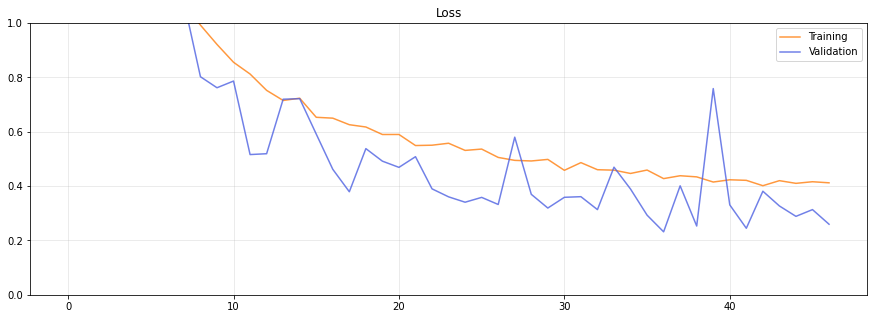

In [ ]:
print(history)
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 1)
plt.title('Loss')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

#Show predictions

In [ ]:
model_others = tfk.models.load_model("Data_Augmentation_no_tomato_v2")

In [ ]:
print(test_gen.class_indices)

{'Apple': 0, 'Blueberry': 1, 'Cherry': 2, 'Corn': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12}


In [ ]:
# return to local colab directory where the unzipped dataset is located

%cd /content

/content


In [ ]:
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=1,
                                               shuffle=False,
                                               seed=seed)

Found 1214 images belonging to 13 classes.


In [ ]:
model_metrics = model_others.evaluate(test_gen, return_dict=True)
print(model_metrics)

1214/1214 [==============================] - 15s 6ms/step - loss: 0.0291 - categorical_accuracy: 0.9909 - accuracy: 0.9909
{'loss': 0.02905905619263649, 'categorical_accuracy': 0.9909390211105347, 'accuracy': 0.9909390211105347}


In [ ]:
predictions = model_others.predict_generator(test_gen, steps=1214)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
ok = [0]*15
error = [0]*15

for i in range(0, 1214):
  for k in range(0,13):
    if(predictions[i][k] == max(predictions[i])):
      if true_classes[i] == k:
        ok[k] += 1
      else:
        error[k] += 1
print("ok:", ok)
print("error:", error)

ok: [99, 47, 58, 120, 147, 174, 99, 75, 72, 27, 161, 55, 69, 0, 0]
error: [4, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0]
good: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())   

[ 0  0  0 ... 12 12 12]


In [ ]:
from sklearn import metrics
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

              precision    recall  f1-score   support

       Apple       0.95      1.00      0.98        99
   Blueberry       1.00      1.00      1.00        47
      Cherry       1.00      0.98      0.99        59
        Corn       0.99      0.98      0.99       122
       Grape       0.98      1.00      0.99       147
      Orange       1.00      0.99      1.00       175
       Peach       0.98      1.00      0.99        99
      Pepper       1.00      0.96      0.98        78
      Potato       1.00      1.00      1.00        72
   Raspberry       1.00      1.00      1.00        27
     Soybean       1.00      0.99      1.00       162
      Squash       1.00      0.95      0.97        58
  Strawberry       1.00      1.00      1.00        69

    accuracy                           0.99      1214
   macro avg       0.99      0.99      0.99      1214
weighted avg       0.99      0.99      0.99      1214

